In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
from matplotlib import pyplot as plt
import matplotlib
from matplotlib.cm import get_cmap

cmap = get_cmap('bwr')

os.chdir('/home/bruno/datacloud')

plt.style.use('seaborn-dark')

plt.rcParams['axes.grid'] = True
plt.rcParams['figure.figsize'] = (15, 5)

from scipy import signal
from itertools import product

import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm

In [2]:
from theory.core import TheoreticalWavelet, Pipe, Rock

# PLAYGROUND BEFORE MODELING 

This is where we can visualize the wavelets with the pick on top of it given a range of values.
Its useful to visualize what times to expect and plan the windows boundaries.

## Playground parameters

In [10]:
COMPONENT = 'tangential'

window = 210
alpha_or_beta_range = np.arange(50, 3000 + 300, 300)
rho_range = np.arange(1500, 2000 + 500, 500)
Rb = 0.16

BANDPASS_FILTER = [30, 45, 160, 200]

RC_AXIAL = 0.272
DELAY_BITSUB_AXIAL = 0.53

RC_TANGENTIAL = -0.141
DELAY_BITSUB_TANGENTIAL = 1.09

axial_windows = (-.002, 0.002) # left value is left boundary around the peak to extract maxima
tangential_windows = (-.002, 0.002) # right values if right boundary around the peak to extract maxima

pipe_alpha = 4875 # velocity of the pipe
pipe_rho = 7200 # density of the pipe

100%|██████████| 22/22 [00:07<00:00,  3.24it/s]


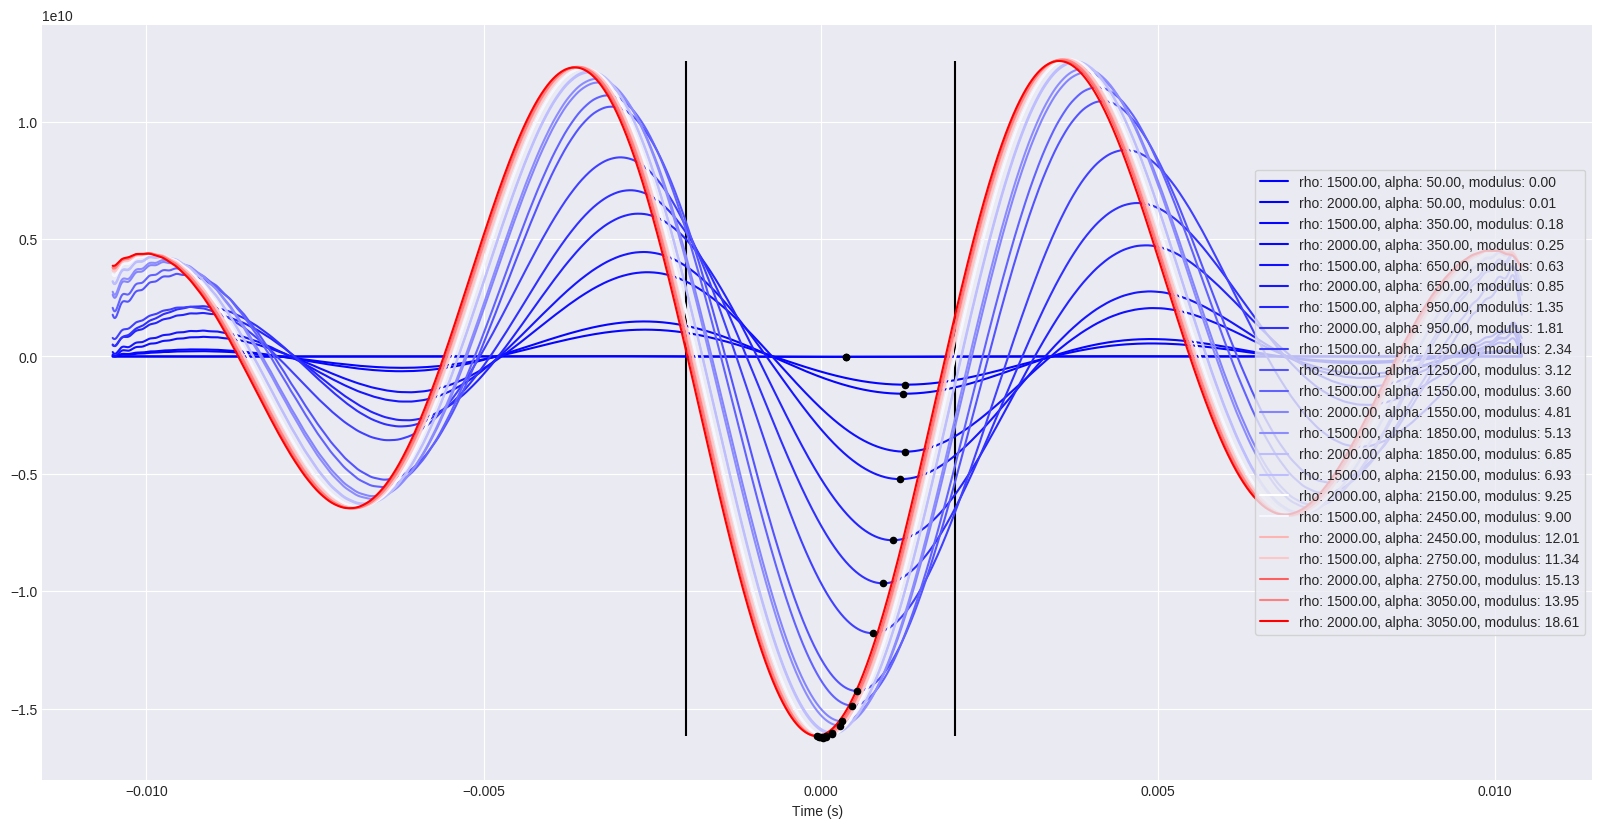

In [6]:
mod_range = (np.product(list(product(alpha_or_beta_range**2, rho_range)), axis=1)/1e9)
min_mod, max_mod = mod_range.min(), mod_range.max()

pipe = Pipe(Rb=Rb, alpha=pipe_alpha, rho=pipe_rho)
ax = plt.axes()
for a, r in tqdm(product(alpha_or_beta_range, rho_range), total=len(list(product(alpha_or_beta_range, rho_range)))):
    mod = (r*(a**2)) * (1e-9)
    rock = Rock(alpha=a, beta=a, rho=r)

    theoretical = TheoreticalWavelet(pipe, rock, component=COMPONENT, nyquist=5000, filterby=BANDPASS_FILTER)
    resampled_time = theoretical.get_time_range_for_window(window)/1000
    resampled_time = np.linspace(resampled_time.min(), resampled_time.max(), 100000)
    
    w = getattr(theoretical, 'primary_in_time_domain')(window=None, filtered=False)                                    
#     w += theoretical.pegleg_effect(delay_in_ms=DELAY_BITSUB_AXIAL, RC=RC_AXIAL, window=None)
    w += theoretical.pegleg_effect(delay_in_ms=DELAY_BITSUB_TANGENTIAL, RC=RC_TANGENTIAL, window=None)
    
    
    w = np.gradient(w, theoretical.sampling_interval)

    w = signal.filtfilt(theoretical.fir_taps, 1, w)                                                                                                                                      
    wavelet_full = theoretical.get_window_from_center(window, w)
    
    wavelet_full = signal.resample(wavelet_full, 100000)
    if COMPONENT == 'axial':
        constrained_indices = np.where((resampled_time > axial_windows[0]) & (resampled_time < axial_windows[1]))
    else:
        constrained_indices = np.where((resampled_time > tangential_windows[0]) & (resampled_time < tangential_windows[1]))
        
    constrained_wavelet = np.zeros_like(wavelet_full)
    constrained_wavelet[constrained_indices] = wavelet_full[constrained_indices]
    max_ind = np.argmin(constrained_wavelet)
    delay = resampled_time[max_ind]

    ax.plot(resampled_time, wavelet_full, color=cmap((mod-min_mod)/max_mod), zorder=5, label='rho: {:.2f}, alpha: {:.2f}, modulus: {:.2f}'.format(r, a, mod))
    ax.scatter(resampled_time[max_ind], wavelet_full[max_ind], s=20, c='k', zorder=10)

ax.figure.dpi = 100
ax.figure.set_size_inches(20,10)
ax.legend(loc='right', frameon=True)
if COMPONENT == 'axial':
    ax.vlines(axial_windows, w.min(), w.max())
else:
    ax.vlines(tangential_windows, w.min(), w.max())
    
t = ax.set_xlabel('Time (s)')

# PARAMETERS FOR THE MODELING

In [11]:
MINE = 'Rio Tinto - West Angelas'
BANDPASS_FILTER = [30, 45, 160, 200]

RC_AXIAL = 0.272
DELAY_BITSUB_AXIAL = 0.53

RC_TANGENTIAL = -0.141
DELAY_BITSUB_TANGENTIAL = 1.09

MODULUS_RANGE = (.5, 4) # Minimum and maximum modulus values you want to model

Rb = 0.16 # Rb is the radius of the bit contacting rock

axial_windows = (-.002, 0.002) # left value is left boundary around the peak to extract maxima
tangential_windows = (-.002, 0.002) # right values if right boundary around the peak to extract maxima

pipe_alpha = 4875 # velocity of the pipe
pipe_rho = 7200 # density of the pipe

rock_alpha_range = (500, 4000, 100) # range of the c velocity modeling
rock_beta_range = (300, 2000, 50) # range of the s velocity modeling

rock_rho_range = (1500, 3000 + 500, 500) # range of the density modeling

# Modeling Axial Times 

In [8]:
alpha_range = np.arange(*rock_alpha_range)
rho_range = np.arange(*rock_rho_range)

window = 210
axial_delays = []
axial_modulus = []

pipe = Pipe(Rb=Rb, alpha=pipe_alpha, rho=pipe_rho)
wavelets = []
for a, r in tqdm(product(alpha_range, rho_range), total=len(list(product(alpha_range, rho_range)))):
    rock = Rock(alpha=a, beta=a, rho=r)
    theoretical = TheoreticalWavelet(pipe, rock, component='axial', nyquist=5000, filterby=BANDPASS_FILTER)
    time_range = theoretical.get_time_range_for_window(window)/1000
    resampled_time = np.linspace(time_range.min(), time_range.max(), 100000)
    
    w = getattr(theoretical, 'primary_in_time_domain')(window=None, filtered=False)                                    
    w += theoretical.pegleg_effect(delay_in_ms=DELAY_BITSUB_AXIAL, RC=RC_AXIAL, window=None)
    
    w = np.gradient(w, theoretical.sampling_interval)
    w = signal.filtfilt(theoretical.fir_taps, 1, w)                                                                                                                                      
    w = theoretical.get_window_from_center(window, w)
        
    wavelet_full = signal.resample(w, 100000)

    constrained_indices = np.where((resampled_time > axial_windows[0]) & (resampled_time < axial_windows[1]))
        
    constrained_wavelet = np.zeros_like(wavelet_full)
    constrained_wavelet[constrained_indices] = wavelet_full[constrained_indices]
    max_ind = np.argmax(constrained_wavelet)
    delay = resampled_time[max_ind]
    
    axial_delays.append(delay)
    mod = (r*(a**2)) * (1e-9)
    axial_modulus.append(mod)
    
axial_delays = np.asarray(axial_delays)
# axial_delays = axial_delays + (0.0000001 - axial_delays.min())

axial_modulus = np.asarray(axial_modulus)

100%|██████████| 140/140 [00:31<00:00,  4.20it/s]


## Quick QC Axial

Text(0.5, 1.0, 'Time vs Modulus')

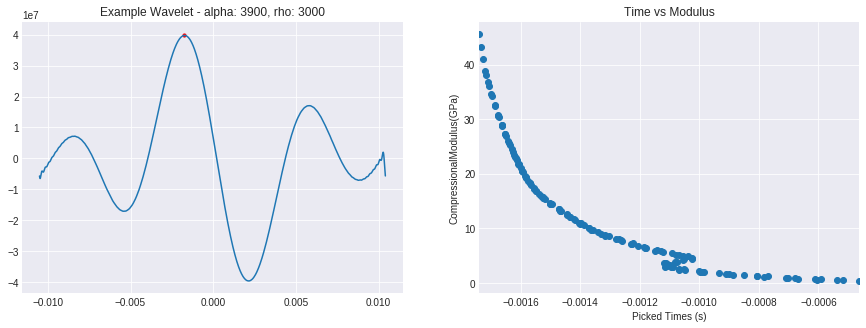

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].plot(resampled_time, wavelet_full)
axes[0].scatter(resampled_time[max_ind], wavelet_full[max_ind], s=10, c='r')
axes[0].set_title('Example Wavelet - alpha: {}, rho: {}'.format(a, r))
axes[1].scatter(axial_delays, axial_modulus)
axes[1].set_xlabel('Picked Times (s)'); axes[1].set_ylabel('CompressionalModulus(GPa)')
axes[1].set_xlim(axial_delays.min(), axial_delays.max())
axes[1].set_title('Time vs Modulus')

# Modeling Tangential Times 

In [13]:
window = 210
tangential_delays = []
tangential_modulus = []

beta_range = np.arange(*rock_beta_range)
rho_range = np.arange(*rock_rho_range)

pipe = Pipe(Rb=Rb, alpha=pipe_alpha, rho=pipe_rho)
wavelets = []
for b, r in tqdm(product(beta_range, rho_range), total=len(list(product(beta_range, rho_range)))):
    rock = Rock(beta=b, rho=r, component='tangential')
    theoretical = TheoreticalWavelet(pipe, rock, component='tangential', nyquist=5000, filterby=BANDPASS_FILTER)
    time_range = theoretical.get_time_range_for_window(window)/1000
    resampled_time_full = np.linspace(time_range.min(), time_range.max(), 100000)
    
    w = getattr(theoretical, 'primary_in_time_domain')(window=None, filtered=False)                                    
    w += theoretical.pegleg_effect(delay_in_ms=DELAY_BITSUB_TANGENTIAL, RC=RC_TANGENTIAL, window=None)
    w = np.gradient(w, theoretical.sampling_interval)
    w = signal.filtfilt(theoretical.fir_taps, 1, w)                                                                                                                                      
    w = theoretical.get_window_from_center(window, w)
    
    wavelet_full = signal.resample(w, 100000)
    
    constrained_indices = np.where((resampled_time > tangential_windows[0]) & (resampled_time < tangential_windows[1]))
        
    constrained_wavelet = np.zeros_like(wavelet_full)
    constrained_wavelet[constrained_indices] = wavelet_full[constrained_indices]
    max_ind = np.argmin(constrained_wavelet)
    delay = resampled_time[max_ind]

    tangential_delays.append(delay)
    mod = (r*(b**2)) * (1e-9)
    tangential_modulus.append(mod)
    
tangential_delays = np.asarray(tangential_delays)
# tangential_delays = tangential_delays + (0.0000001 - tangential_delays.min())

tangential_modulus = np.asarray(tangential_modulus)

100%|██████████| 136/136 [00:38<00:00,  5.80it/s]


## Quick QC Tangential

Text(0.5, 1.0, 'Time vs Modulus')

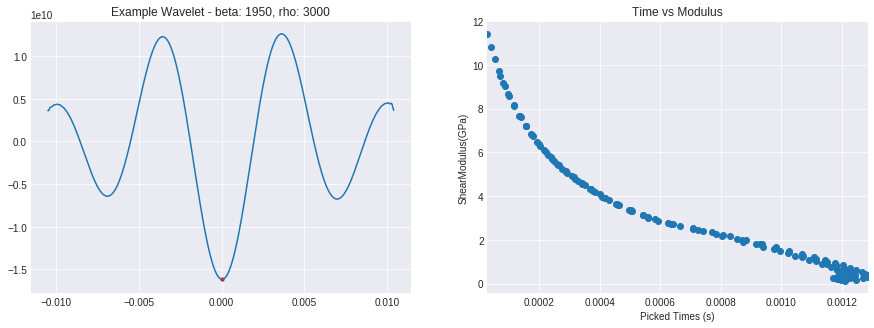

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].plot(resampled_time, wavelet_full)
axes[0].scatter(resampled_time[max_ind], wavelet_full[max_ind], s=10, c='r')
axes[0].set_title('Example Wavelet - beta: {}, rho: {}'.format(b, r))
axes[1].scatter(tangential_delays, tangential_modulus)
axes[1].set_xlabel('Picked Times (s)'); axes[1].set_ylabel('ShearModulus(GPa)')
axes[1].set_xlim(tangential_delays.min(), tangential_delays.max())
axes[1].set_title('Time vs Modulus')

# Check Distribution 

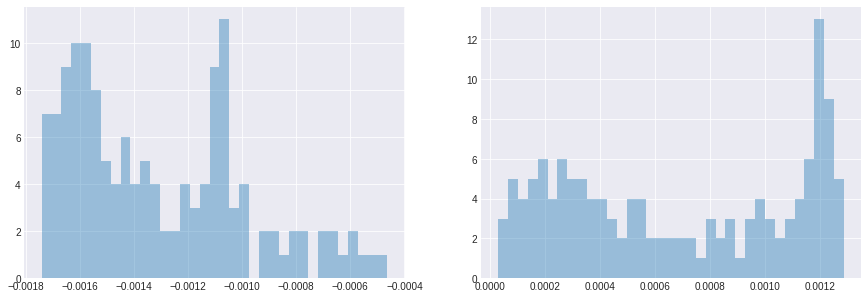

In [15]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(15,5))

sns.distplot(axial_delays, label='axial_time', ax=ax1, kde=False, bins=35)
sns.distplot(tangential_delays, label='tangential_time', ax=ax2, kde=False, bins=35)

# A bigger plot of the picked times

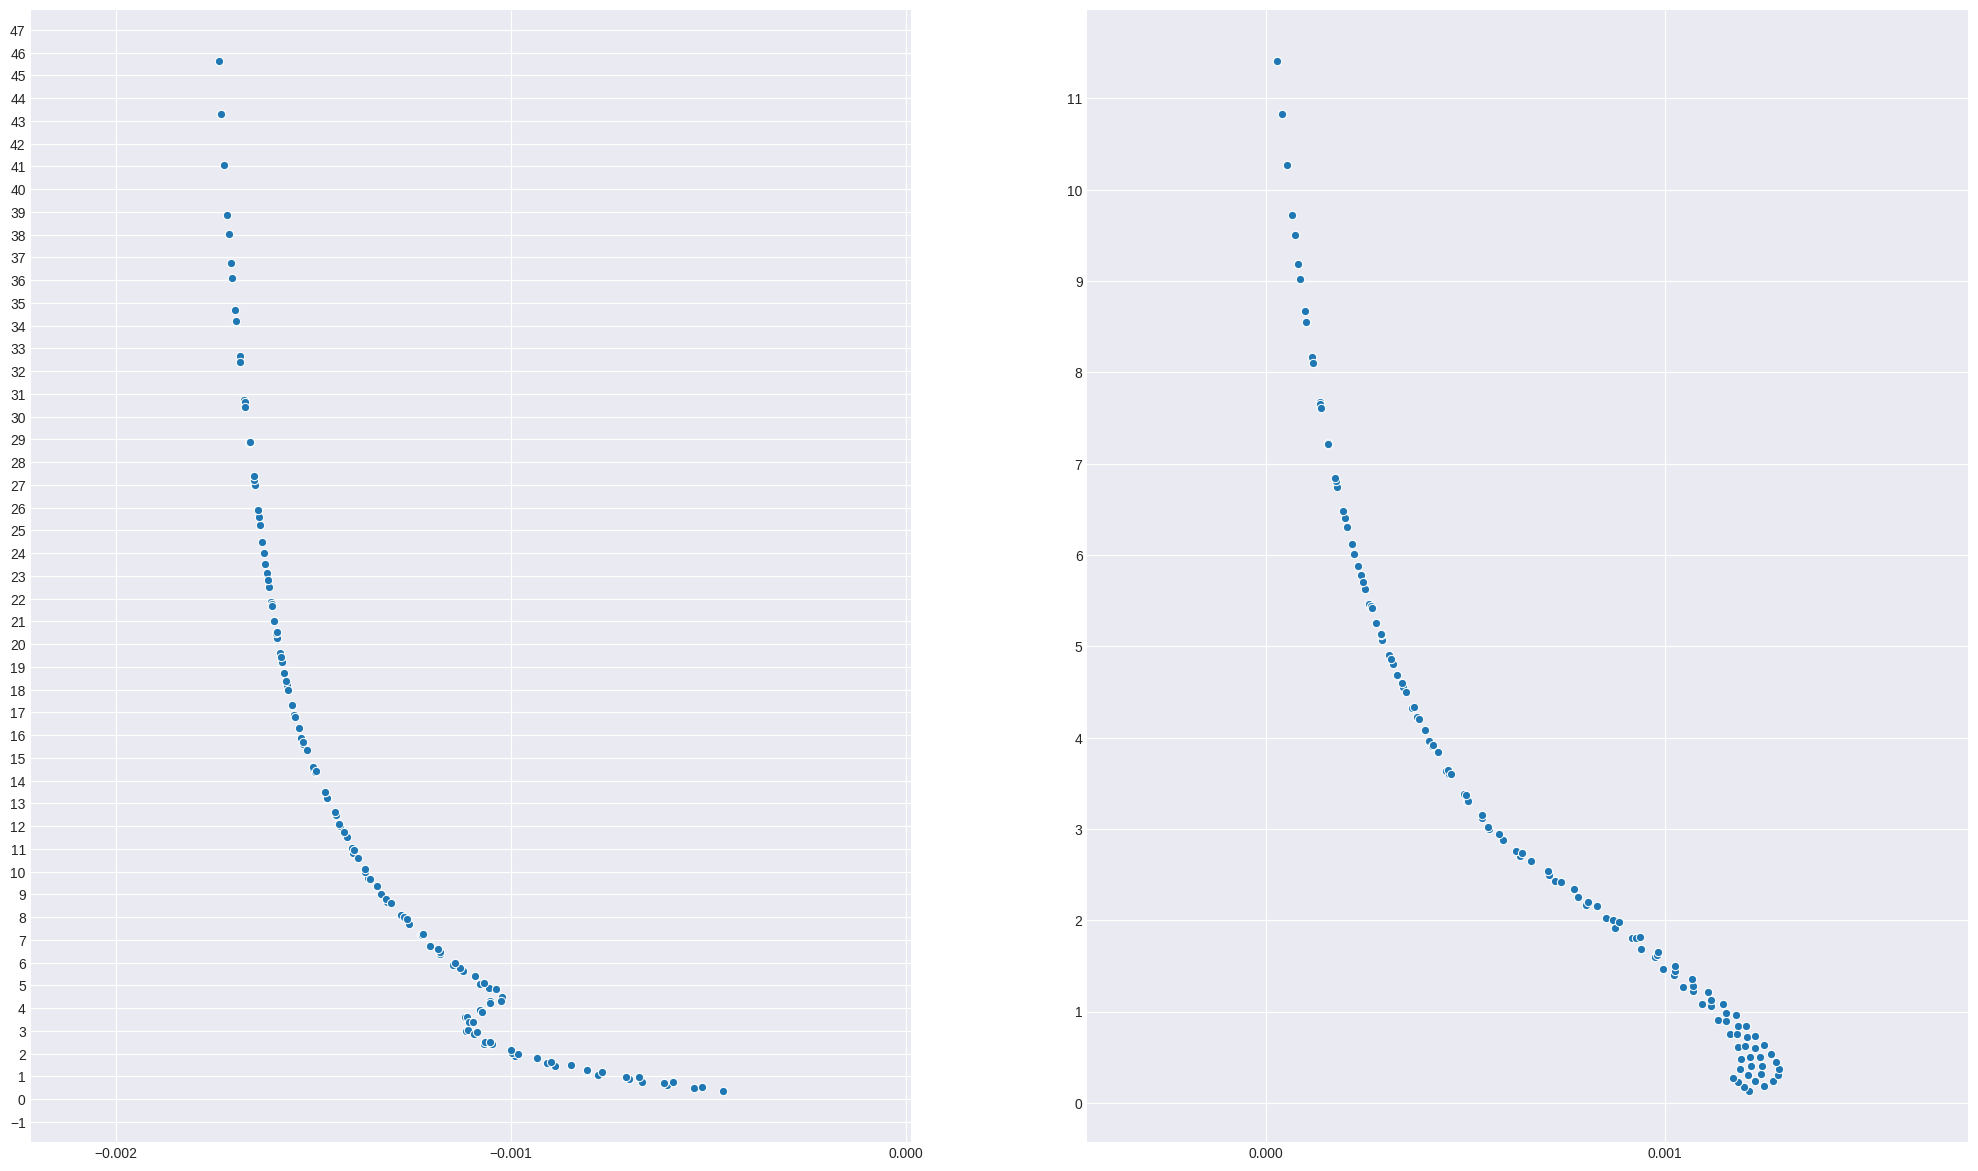

In [16]:
import matplotlib.ticker as ticker


fig, axes = plt.subplots(1, 2, figsize=(25,15), dpi=100, sharey=False)
sns.scatterplot(axial_delays, axial_modulus, ax=axes[0])
sns.scatterplot(tangential_delays, tangential_modulus, ax=axes[1])
for ax in axes.ravel():
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(0.001))
    ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
    
#     ax.set_ylim(0, MODULUS_RANGE[1])

# axes[0].set_xlim(0.0005, 0.0012)
# axes[1].set_xlim(-.002, -.0015)

# Modeling

## This is a bunch of functions we can fit our model to. 

In [17]:
from scipy.optimize import curve_fit

def line_function(x, a, b):
    return a * np.asarray(x) + b

def power_func(x, a, b, c):
    return a * (np.asarray(x+b)**c)

def power_func2(x, a, b, c, d, kk,  tt, aa, ap, bb, cc, e, ):
    return (((a * ((np.asarray(x)+b)**c) + d) + (kk*x) + tt) / (aa  * (np.asarray(x) ** (2)) + bb * x + cc) * e)

def power_func3(x, a, b, c, d, aa, ap, bb, cc, e, ):
    return ((a * ((np.asarray(x)+b)**c) + d) / (aa  * (np.asarray(x) ** (2)) + bb * x + cc) * e)

def power_func4(x, a, b, c, d, aa, bb, e, ):
    return ((a * ((np.asarray(x)+b)**c) + d)  / (aa * np.asarray(x) + bb) * e)

def exponential_func(x, a, b, c):
    return a * np.exp(-b * np.asarray(x)) + c

## Select which function to use for each component

In [18]:
current_axial_func = line_function

current_tangential_func = line_function

## Removing modulus for the fitting 

In [19]:
axial_modulus

array([ 0.375,  0.5  ,  0.625,  0.75 ,  0.54 ,  0.72 ,  0.9  ,  1.08 ,
        0.735,  0.98 ,  1.225,  1.47 ,  0.96 ,  1.28 ,  1.6  ,  1.92 ,
        1.215,  1.62 ,  2.025,  2.43 ,  1.5  ,  2.   ,  2.5  ,  3.   ,
        1.815,  2.42 ,  3.025,  3.63 ,  2.16 ,  2.88 ,  3.6  ,  4.32 ,
        2.535,  3.38 ,  4.225,  5.07 ,  2.94 ,  3.92 ,  4.9  ,  5.88 ,
        3.375,  4.5  ,  5.625,  6.75 ,  3.84 ,  5.12 ,  6.4  ,  7.68 ,
        4.335,  5.78 ,  7.225,  8.67 ,  4.86 ,  6.48 ,  8.1  ,  9.72 ,
        5.415,  7.22 ,  9.025, 10.83 ,  6.   ,  8.   , 10.   , 12.   ,
        6.615,  8.82 , 11.025, 13.23 ,  7.26 ,  9.68 , 12.1  , 14.52 ,
        7.935, 10.58 , 13.225, 15.87 ,  8.64 , 11.52 , 14.4  , 17.28 ,
        9.375, 12.5  , 15.625, 18.75 , 10.14 , 13.52 , 16.9  , 20.28 ,
       10.935, 14.58 , 18.225, 21.87 , 11.76 , 15.68 , 19.6  , 23.52 ,
       12.615, 16.82 , 21.025, 25.23 , 13.5  , 18.   , 22.5  , 27.   ,
       14.415, 19.22 , 24.025, 28.83 , 15.36 , 20.48 , 25.6  , 30.72 ,
      

In [20]:
axial_delays_clipped = axial_delays[((axial_modulus) < 2.5) & (axial_modulus > 0)]
axial_modulus_clipped = axial_modulus[((axial_modulus) < 2.5) & (axial_modulus > 0)]
                                      
tangential_delays_clipped = tangential_delays[((tangential_modulus) < 3) & (tangential_modulus > .5)]
tangential_modulus_clipped = tangential_modulus[((tangential_modulus) < 3) & (tangential_modulus > .5)]

In [21]:
## Polynomial fitting 

# ax_x, ax_y = axial_delays_clipped, axial_modulus_clipped
# ax_poly = np.poly1d(np.polyfit(ax_x, ax_y, 12))

# tn_x, tn_y = tangential_delays_clipped, tangential_modulus_clipped
# tn_poly = np.poly1d(np.polyfit(tn_x, tn_y, 7))

In [22]:
axial_const = curve_fit(current_axial_func, 
                        axial_delays_clipped,
                        axial_modulus_clipped,
                        maxfev=1000000)[0]

In [23]:
tangential_const = curve_fit(current_tangential_func, 
                             tangential_delays_clipped,
                             tangential_modulus_clipped,
                             maxfev=1000000)[0]

# Look at the equations 

In [25]:
print('axial:', '''{} * x + {}'''.format(*axial_const))

print('tangential:', '''{} * x + {}'''.format(*tangential_const))

axial: -3393.4649035979996 * x + -1.376275531470835
tangential: -3581.7282063716816 * x + 5.0682534138434985


In [26]:
import matplotlib.ticker as ticker
import matplotlib

In [27]:
matplotlib.use('agg')

Text(0.5, 0.98, 'Rio Tinto - West Angelas')

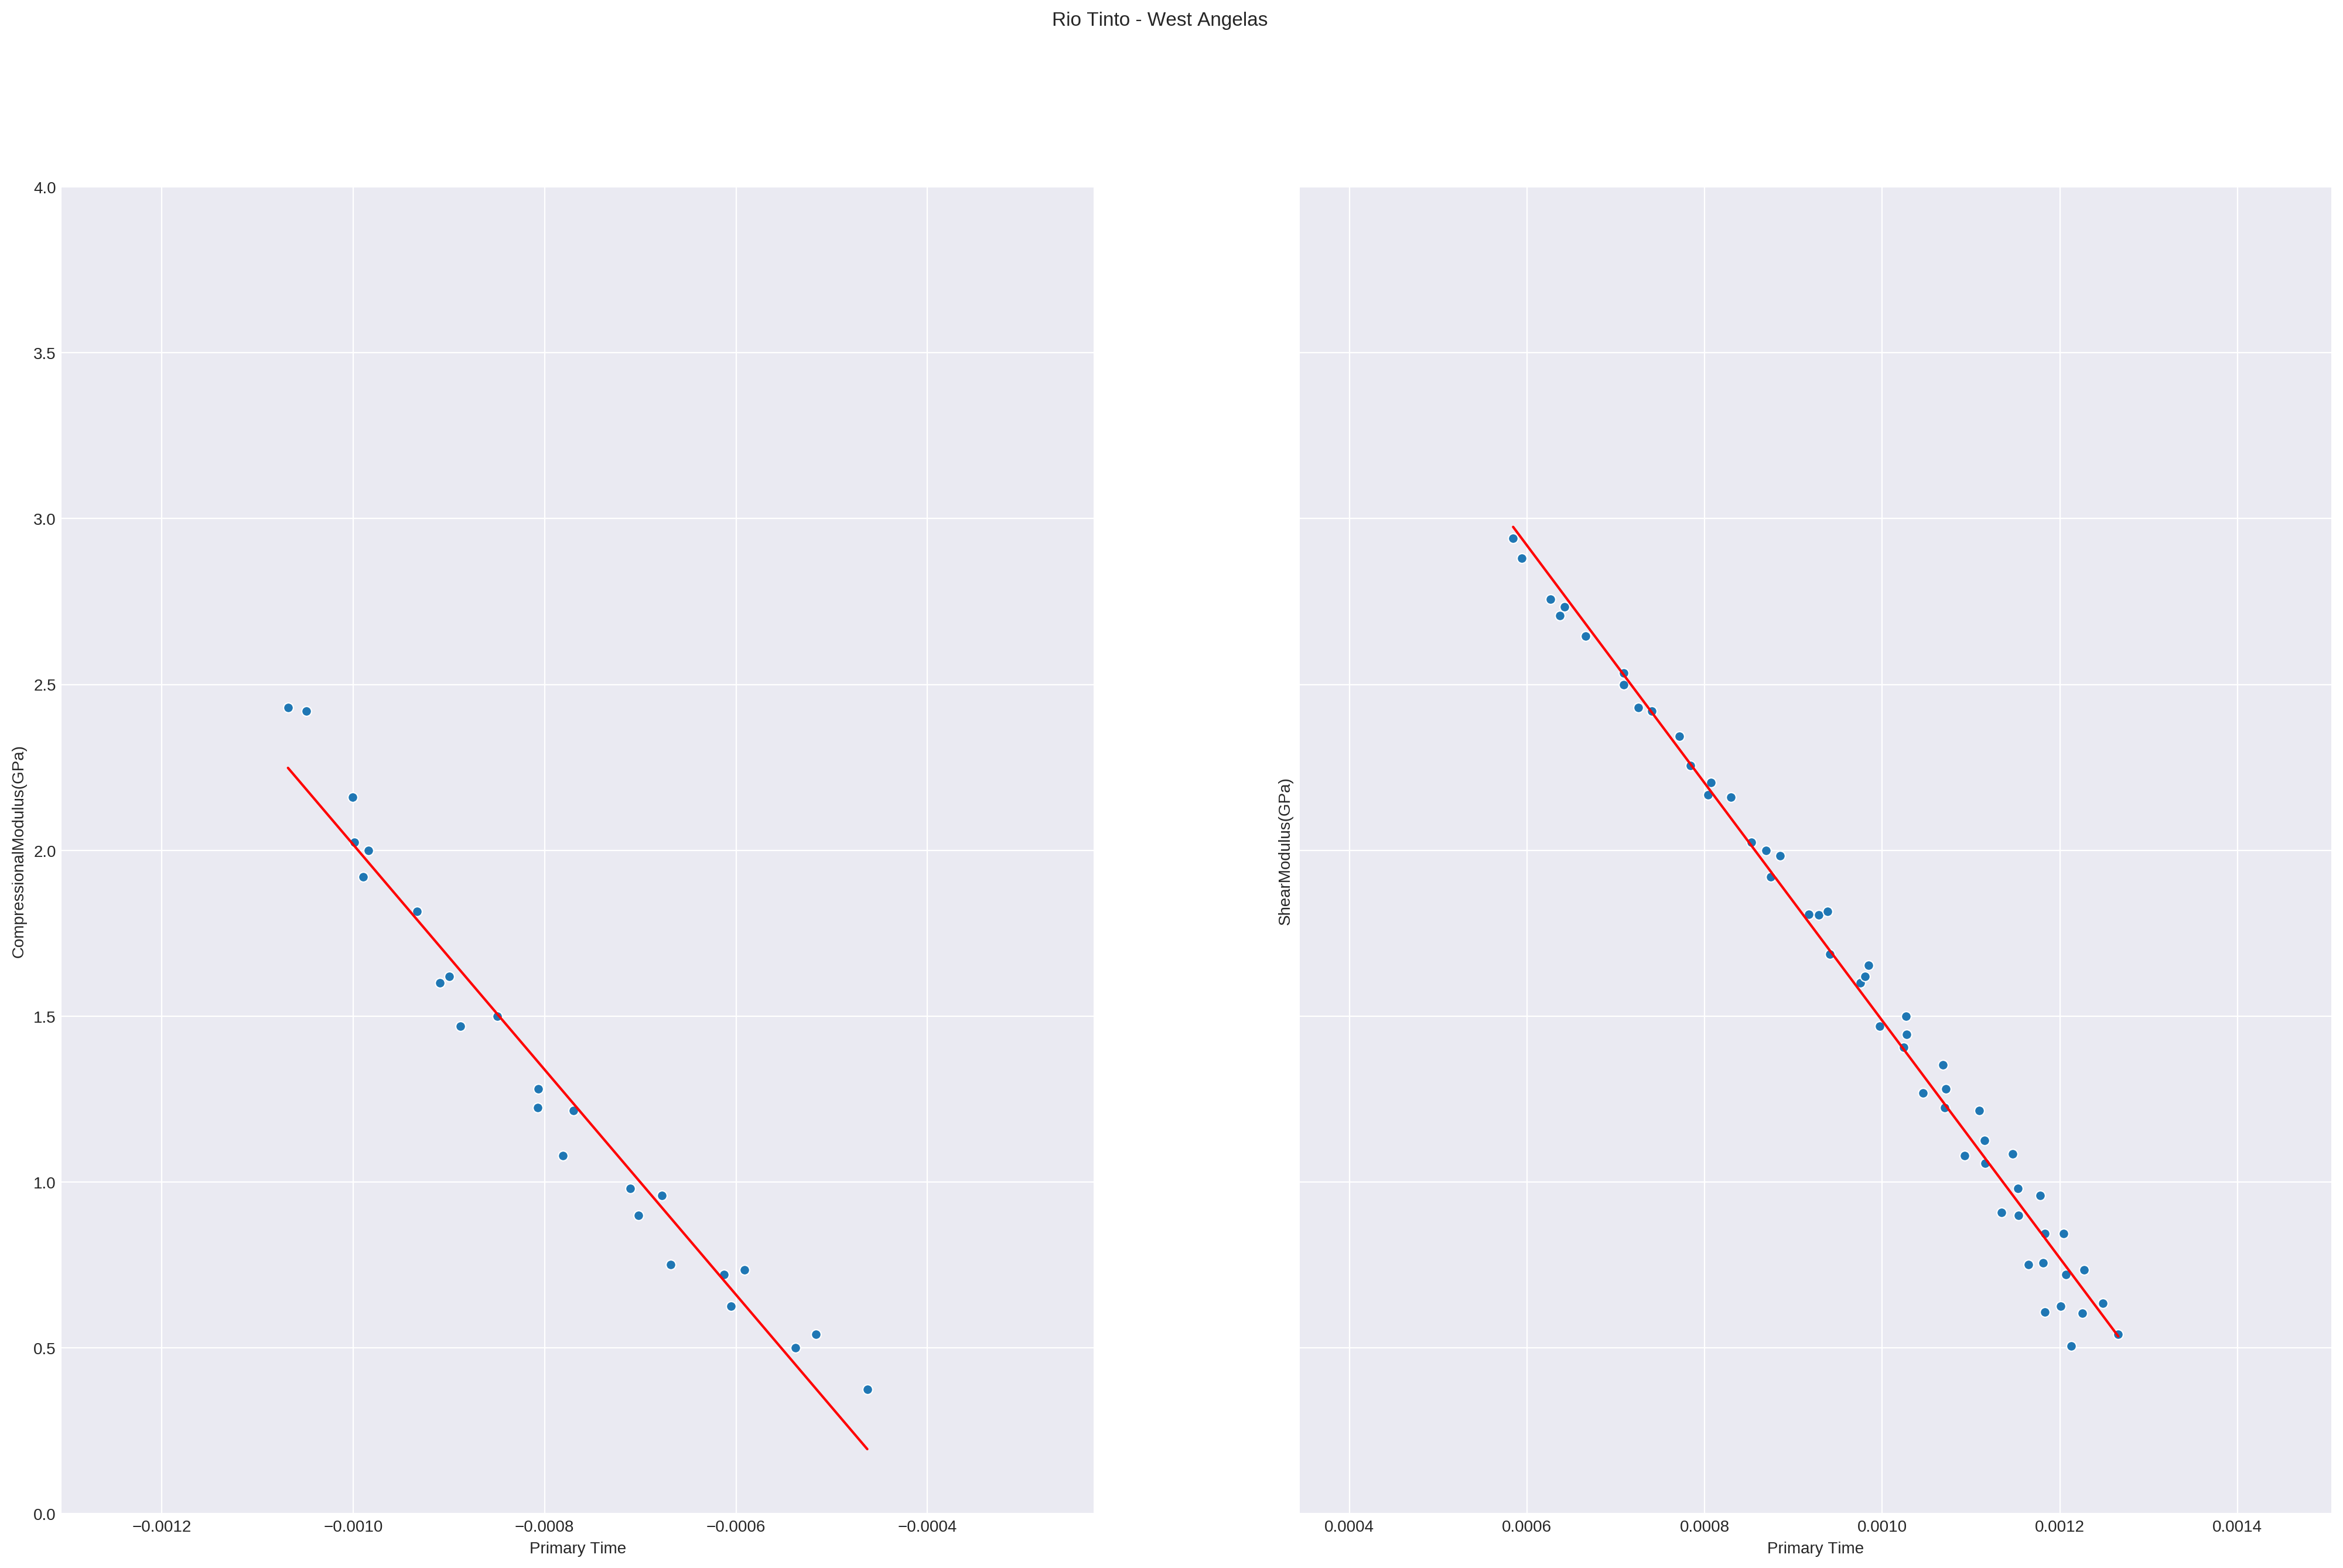

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(25,15), dpi=200, sharey=True)
sns.scatterplot(axial_delays_clipped, axial_modulus_clipped, ax=axes[0])
sns.scatterplot(tangential_delays_clipped, tangential_modulus_clipped, ax=axes[1])

axes[0].plot(np.linspace(axial_delays_clipped.min(), axial_delays_clipped.max()), current_axial_func(np.linspace(axial_delays_clipped.min(), axial_delays_clipped.max()), *axial_const.round(5)), '-', color='r')
axes[1].plot(np.linspace(tangential_delays_clipped.min(), tangential_delays_clipped.max()), current_tangential_func(np.linspace(tangential_delays_clipped.min(), tangential_delays_clipped.max()), *tangential_const.round(5)), '-', color='r')


axes[0].set_xlabel('Primary Time')
axes[0].set_ylabel('CompressionalModulus(GPa)')
axes[1].set_xlabel('Primary Time')
axes[1].set_ylabel('ShearModulus(GPa)')

# axes[0].set_xlim(axial_delays.min(), axial_delays.max())
# axes[1].set_xlim(0.002, tangential_delays.max())

for ax in axes.ravel():
    ax.set_ylim(0, MODULUS_RANGE[1])
#     ax.set_yscale('log')

# axes[0].set_xlim(0.0005, 0.0012)
# axes[1].set_xlim(-.002, -.0015)
fig.suptitle(MINE)

In [143]:
bandpass_str = '-'.join([str(s) for s in BANDPASS_FILTER])

axial_lookup_table = pd.DataFrame(np.c_[np.asarray(list(product(alpha_range, rho_range))), axial_modulus, axial_delays], columns=['alpha', 'rho', 'modulus', 'primary_time'])
# axial_lookup_table = axial_lookup_table.loc[axial_lookup_table['modulus'] > 7.5]
axial_lookup_table.to_csv('lp_projects/west_angelas//data/20190730-{}-CompressionalModulus_LookupTable.csv'.format(bandpass_str), index=False)

tangential_lookup_table = pd.DataFrame(np.c_[np.asarray(list(product(beta_range, rho_range))), tangential_modulus, tangential_delays], columns=['beta', 'rho', 'modulus', 'primary_time'])
# tangential_lookup_table = tangential_lookup_table.loc[tangential_lookup_table['modulus'] > 4]
tangential_lookup_table.to_csv('lp_projects/west_angelas/data/20190730-{}-ShearModulus_LookupTable.csv'.format(bandpass_str), index=False)

# Lookup Table Code

In [144]:
from scipy.interpolate import interp1d

def lookup_table(shifted_time, modulus):
    return interp1d(shifted_time, modulus, fill_value="extrapolate")

In [147]:
axial_lookup = pd.read_csv('lp_projects/west_angelas/data/20190730-{}-CompressionalModulus_LookupTable.csv'.format(bandpass_str))
tangential_lookup = pd.read_csv('lp_projects/west_angelas/data/20190730-{}-ShearModulus_LookupTable.csv'.format(bandpass_str))

ALookupTable = lookup_table(axial_lookup.primary_time, axial_lookup.modulus)
TLookupTable = lookup_table(tangential_lookup.primary_time, tangential_lookup.modulus)

Text(0, 0.5, 'ShearModulus(GPa)')

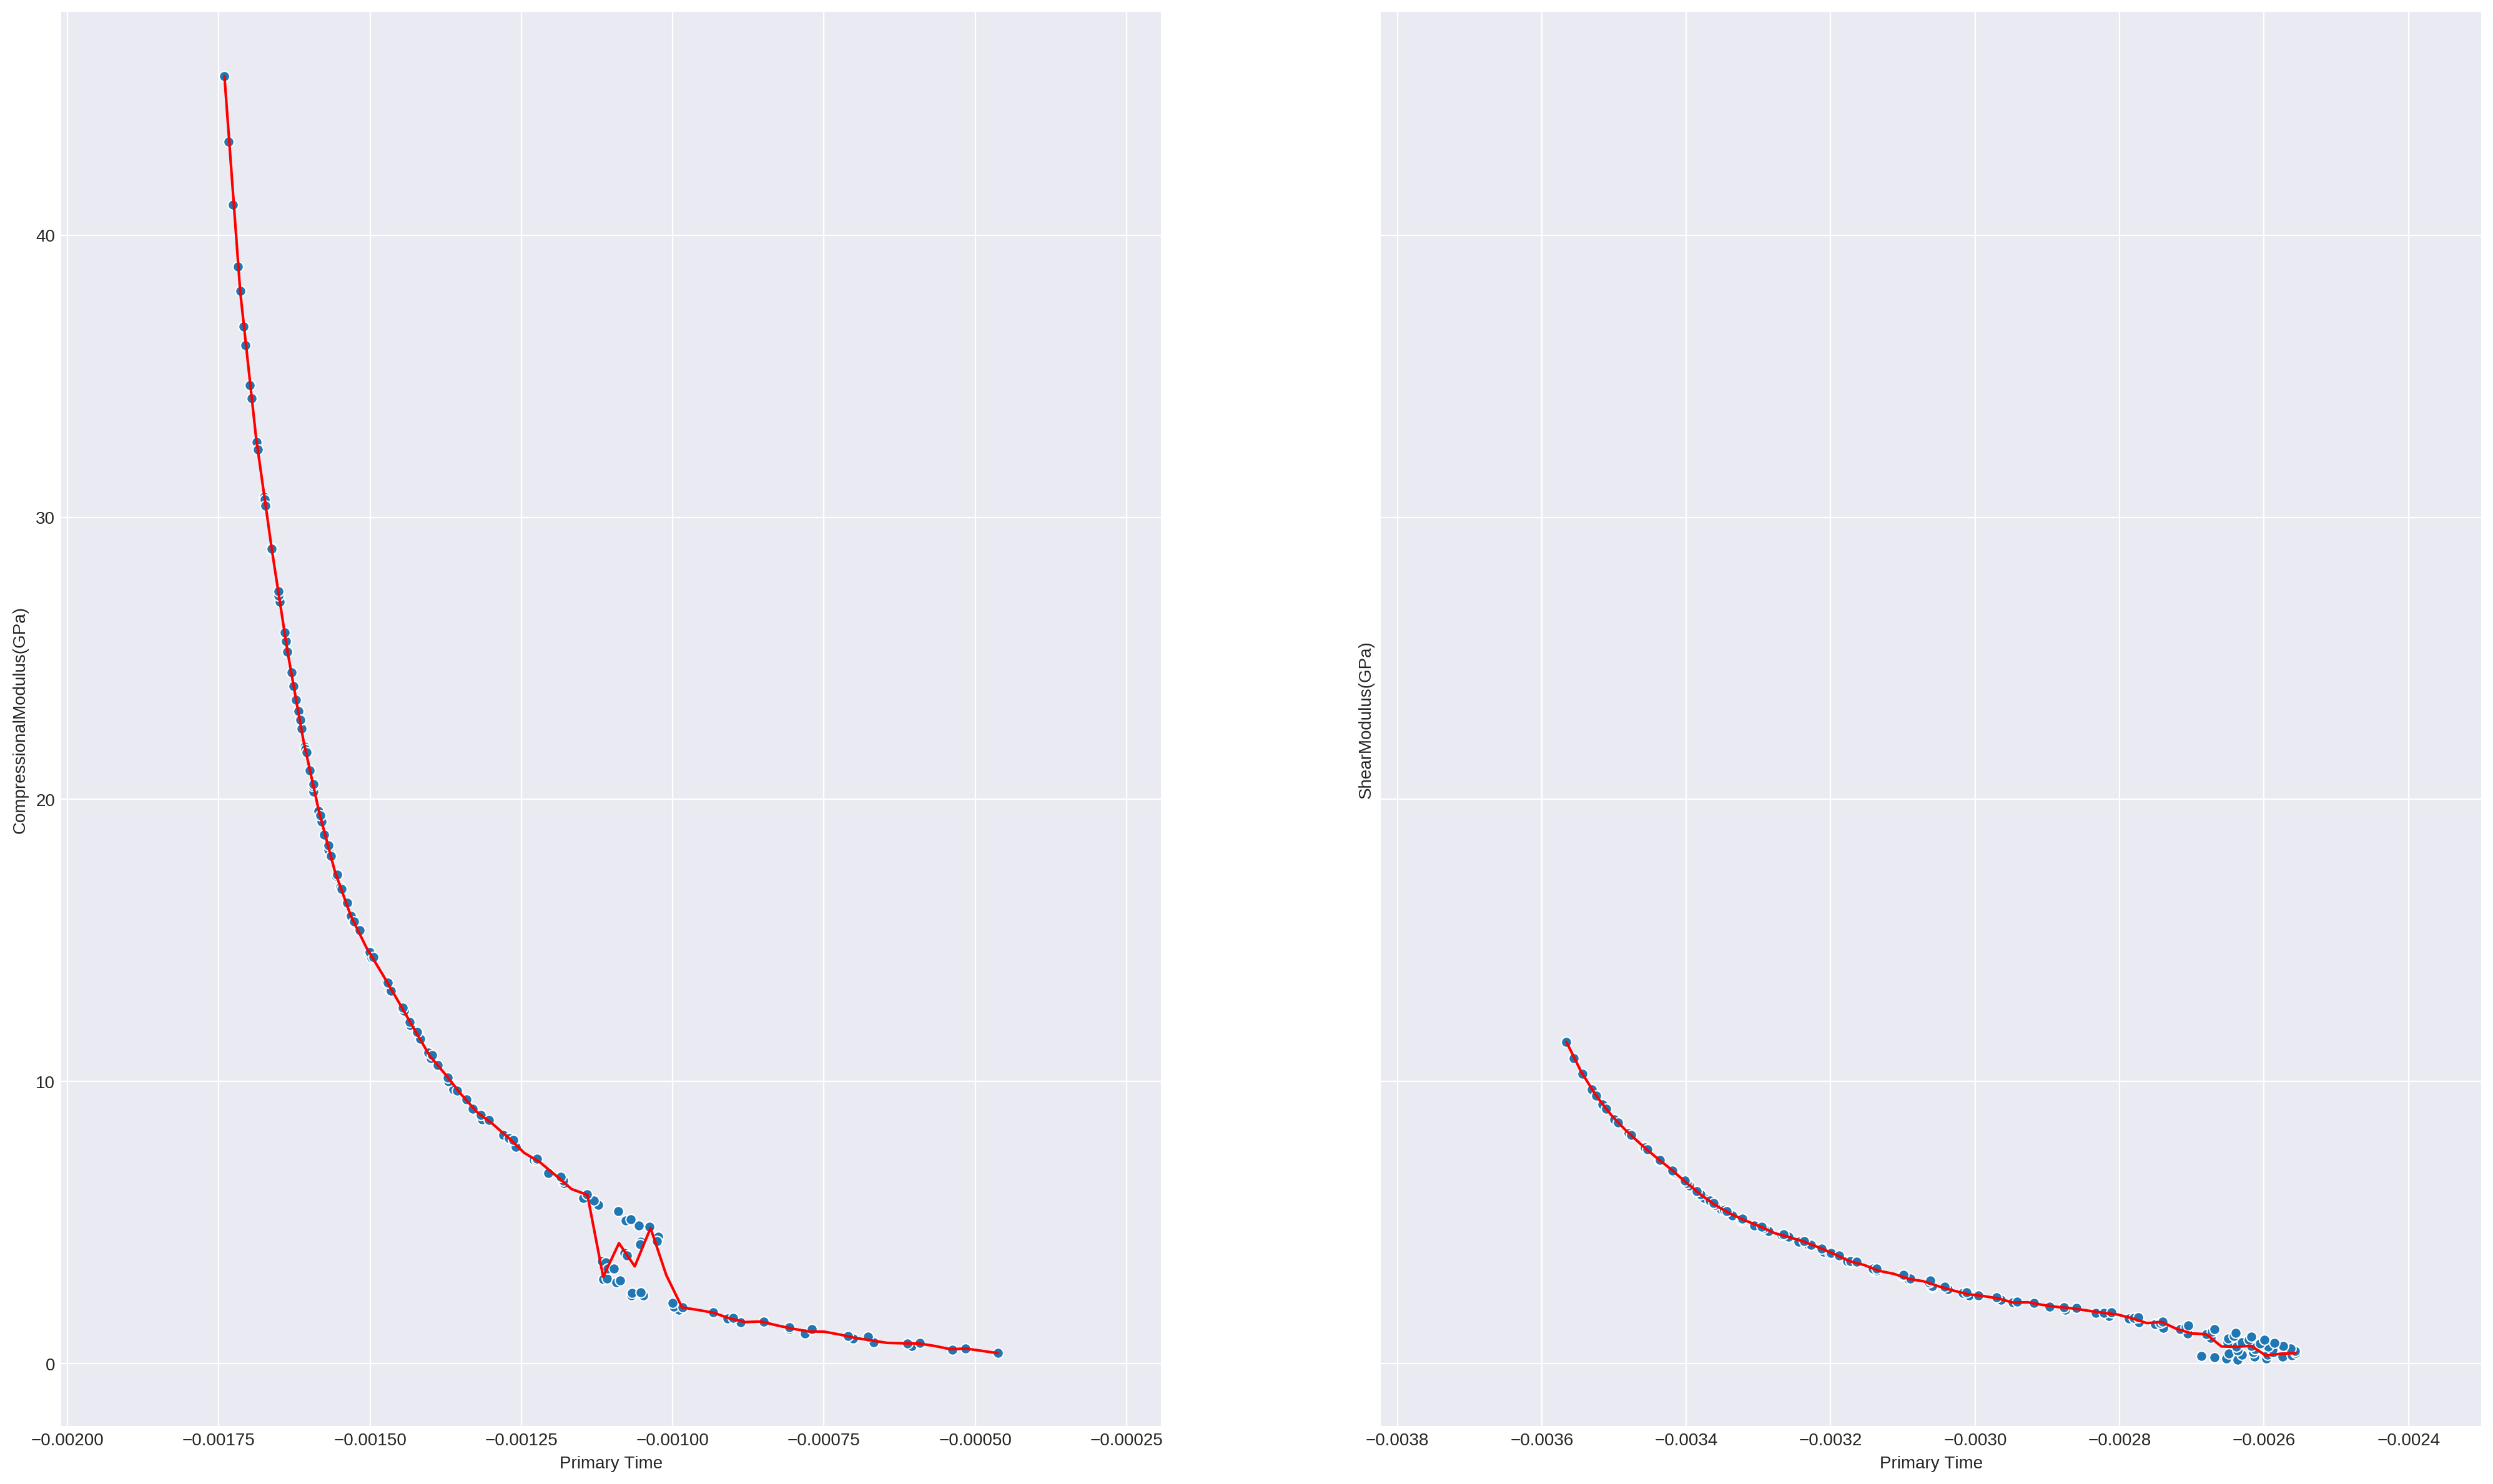

In [152]:
fig, axes = plt.subplots(1, 2, figsize=(25,15), dpi=200, sharey=True)
sns.scatterplot(axial_delays, axial_modulus, ax=axes[0])
sns.scatterplot(tangential_delays, tangential_modulus, ax=axes[1])

axes[0].plot(np.linspace(axial_delays.min(), axial_delays.max()), ALookupTable(np.linspace(axial_delays.min(), axial_delays.max()).reshape(-1, 1)), '-', color='r')
axes[1].plot(np.linspace(tangential_delays.min(), tangential_delays.max()), TLookupTable(np.linspace(tangential_delays.min(), tangential_delays.max()).reshape(-1, 1)), '-', color='r')

axes[0].set_xlabel('Primary Time')
axes[0].set_ylabel('CompressionalModulus(GPa)')
axes[1].set_xlabel('Primary Time')
axes[1].set_ylabel('ShearModulus(GPa)')